In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import xml.etree.ElementTree as ET
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

## Connect to database 

In [2]:
#Lets set up the connection to database
database = "database.sqlite"
conn = sqlite3.connect(database)
df_match= pd.read_sql_query("SELECT * FROM Match",conn)

In [3]:
#Lets print out the name of the tables in the database
pd.read_sql("SELECT * FROM sqlite_master WHERE type='table';", conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
pd.read_sql("SELECT * FROM League;", conn)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


## GET information of english premier league and extract xml information

In [5]:
#Given that we want to find out infomration of the English Premier Leage, lets get the data using SQL query
pl = pd.read_sql("""SELECT id, league_id, stage, season,date, match_api_id,
                     home_team_api_id, (SELECT team_long_name FROM Team WHERE team_api_id = home_team_api_id) home_team, 
                     away_team_api_id, (SELECT team_long_name FROM Team WHERE team_api_id = away_team_api_id) away_team,
                     home_team_goal, away_team_goal, goal, shoton, shotoff, foulcommit,
                     card, cross, corner, possession, B365H, B365D, B365A
                     FROM Match m
                     WHERE league_id = (SELECT id FROM league WHERE name = 'England Premier League')
                     ORDER BY date;
                """, conn)


In [6]:
match_count = pl['id'].size
no_seasons = pl['season'].nunique()
print("The dataframe consists of %d rows spanning %d years of data" % (match_count, no_seasons))
pl['season'].value_counts()

The dataframe consists of 3040 rows spanning 8 years of data


2008/2009    380
2009/2010    380
2010/2011    380
2011/2012    380
2012/2013    380
2013/2014    380
2014/2015    380
2015/2016    380
Name: season, dtype: int64

In [7]:
pl.head()

,id,league_id,stage,season,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,...,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A
0,1730,1729,1,2008/2009,2008-08-16 00:00:00,489043,9825,Arsenal,8659,West Bromwich Albion,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,1.20,6.5,15.00
1,1731,1729,1,2008/2009,2008-08-16 00:00:00,489044,8472,Sunderland,8650,Liverpool,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,5.50,3.6,1.67
2,1732,1729,1,2008/2009,2008-08-16 00:00:00,489045,8654,West Ham United,8528,Wigan Athletic,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,1.91,3.4,4.20
3,1734,1729,1,2008/2009,2008-08-16 00:00:00,489047,8668,Everton,8655,Blackburn Rovers,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>46</comment><event...,2.00,3.3,4.00
4,1735,1729,1,2008/2009,2008-08-16 00:00:00,489048,8549,Middlesbrough,8586,Tottenham Hotspur,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>49</comment><event...,3.20,3.4,2.25


We can see that the dataframe contain XML values which I will try to extract

In [8]:
def calculate_stats_both_teams(xml_document, home_team, away_team, card_type='y'):
    assert card_type == 'y' or card_type == 'r', "Please enter either yellow or red card"
    tree = ET.fromstring(xml_document)
    stat_home_team = 0
    stat_away_team = 0
    
    #Dealing with card type using the root element & the card type argument
    if tree.tag == 'card':
        for child in tree.iter('value'):
            #Some xml docs have no card_type element in the tree. comment section seems to have that information
            try:
                if child.find('comment').text == card_type:
                    if int(child.find('team').text) == home_team:
                        stat_home_team += 1
                    else:
                        stat_away_team += 1
            except AttributeError:
                #Some values in the xml doc don't have team values
                pass
                
        return stat_home_team, stat_away_team
    
    #Lets take the last possession stat which is available from the xml document
    if tree.tag == 'possession':
        try:
            last_value = [child for child in tree.iter('value')][-1]
            return int(last_value.find('homepos').text), int(last_value.find('awaypos').text)
        except:
            return None, None
    
    #Taking care of all other stats by extracting based on the home team & away team api id's
    for team in [int(stat.text) for stat in tree.findall('value/team')]:
        if team == home_team: 
            stat_home_team += 1
        else:
            stat_away_team += 1
    return stat_home_team, stat_away_team

In [9]:
pl[['on_target_shot_home_team','on_target_shot_away_team']] = pl[['shoton','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['shoton'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
pl[['off_target_shot_home_team','off_target_shot_away_team']] = pl[['shotoff','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['shotoff'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand") 
pl[['foul_home_team','foul_away_team']] = pl[['foulcommit','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['foulcommit'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
pl[['yellow_card_home_team','yellow_card_away_team']] = pl[['card','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['card'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")
pl[['red_card_home_team','red_card_away_team']] = pl[['card','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['card'],x['home_team_api_id'],x['away_team_api_id'], card_type='r'), axis = 1,result_type="expand")  
pl[['crosses_home_team','crosses_away_team']] = pl[['cross','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['cross'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
pl[['corner_home_team','corner_away_team']] = pl[['corner','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['corner'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
pl[['possession_home_team','possession_away_team']] = pl[['possession','home_team_api_id','away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x['possession'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")

In [10]:
pl.loc[pl['possession_home_team'].isnull()]
##There is only 6 games whose possession stats were not available which represent only a few pourcentage of the data therefore we can drop them
pl=pl.drop(pl.loc[pl['possession_home_team'].isnull()].index, inplace=False)


In [11]:
pl.describe()

,id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,...,yellow_card_home_team,yellow_card_away_team,red_card_home_team,red_card_away_team,crosses_home_team,crosses_away_team,corner_home_team,corner_away_team,possession_home_team,possession_away_team
count,3034.000000,3034.0,3034.000000,3.034000e+03,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,...,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000
mean,3250.362887,1729.0,19.519446,1.179750e+06,9142.544166,9142.427818,1.552736,1.158207,2.700287,3.953474,...,1.433092,1.819710,0.041859,0.053065,20.914305,16.248846,6.126895,4.812129,51.676994,48.323006
std,877.155346,0.0,10.965512,4.906884e+05,753.333549,753.178006,1.311651,1.143808,1.688307,0.999023,...,1.172118,1.293977,0.205179,0.232857,8.737286,7.376841,3.147969,2.719731,8.640939,8.640939
min,1729.000000,1729.0,1.000000,4.890420e+05,8191.000000,8191.000000,0.000000,0.000000,1.100000,3.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,20.000000
25%,2492.250000,1729.0,10.000000,8.397992e+05,8528.000000,8528.000000,1.000000,0.000000,1.670000,3.300000,...,1.000000,1.000000,0.000000,0.000000,15.000000,11.000000,4.000000,3.000000,46.000000,43.000000
50%,3250.500000,1729.0,20.000000,1.228230e+06,8659.000000,8659.000000,1.000000,1.000000,2.200000,3.600000,...,1.000000,2.000000,0.000000,0.000000,20.000000,15.000000,6.000000,4.000000,52.000000,48.000000
75%,4009.750000,1729.0,29.000000,1.723983e+06,9879.000000,9879.000000,2.000000,2.000000,3.000000,4.200000,...,2.000000,3.000000,0.000000,0.000000,26.000000,21.000000,8.000000,6.000000,57.000000,54.000000
max,4768.000000,1729.0,38.000000,1.989079e+06,10261.000000,10261.000000,9.000000,6.000000,15.000000,11.000000,...,7.000000,9.000000,2.000000,2.000000,72.000000,55.000000,20.000000,19.000000,80.000000,96.000000


In [12]:
pl.columns

Index(['id', 'league_id', 'stage', 'season', 'date', 'match_api_id',
       'home_team_api_id', 'home_team', 'away_team_api_id', 'away_team',
       'home_team_goal', 'away_team_goal', 'goal', 'shoton', 'shotoff',
       'foulcommit', 'card', 'cross', 'corner', 'possession', 'B365H', 'B365D',
       'B365A', 'on_target_shot_home_team', 'on_target_shot_away_team',
       'off_target_shot_home_team', 'off_target_shot_away_team',
       'foul_home_team', 'foul_away_team', 'yellow_card_home_team',
       'yellow_card_away_team', 'red_card_home_team', 'red_card_away_team',
       'crosses_home_team', 'crosses_away_team', 'corner_home_team',
       'corner_away_team', 'possession_home_team', 'possession_away_team'],
      dtype='object')

## Data preparation

In [13]:
##drop the columns that are not required
df= pl.loc[:,'season':'possession_away_team']
##Here I drop bookers prediction because I think it would be too easy to predict the result just by using the booker's prediction
df=df.drop(['goal','B365H','B365D','B365A'], axis=1, inplace=False)
df.columns

Index(['season', 'date', 'match_api_id', 'home_team_api_id', 'home_team',
       'away_team_api_id', 'away_team', 'home_team_goal', 'away_team_goal',
       'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession', 'on_target_shot_home_team', 'on_target_shot_away_team',
       'off_target_shot_home_team', 'off_target_shot_away_team',
       'foul_home_team', 'foul_away_team', 'yellow_card_home_team',
       'yellow_card_away_team', 'red_card_home_team', 'red_card_away_team',
       'crosses_home_team', 'crosses_away_team', 'corner_home_team',
       'corner_away_team', 'possession_home_team', 'possession_away_team'],
      dtype='object')

I have deleted yellow card because I don't think it effect the outcome of the game. However we need to take care of the red cards that can change completly the outcome of the match


## Creating a cell result

In [14]:
##add column result with no value with the result for the home team 2=win, 1=draw, 0=loss
df.loc[df['home_team_goal'] > df['away_team_goal'], 'result'] = 2
df.loc[df['home_team_goal'] ==df['away_team_goal'], 'result'] = 1
df.loc[df['home_team_goal'] < df['away_team_goal'], 'result'] = 0

## Analysing

In [15]:
##Select only columns to plot in side bar: home team goals, away team goals, on target shots home, off target shots home, red cards, possession home
df_plot=df.loc[:,['home_team_goal','away_team_goal','on_target_shot_home_team','off_target_shot_home_team','red_card_home_team','red_card_away_team','possession_home_team','result']]
print(enumerate(df_plot.drop(columns='result').columns))
df_plot.describe()

,home_team_goal,away_team_goal,on_target_shot_home_team,off_target_shot_home_team,red_card_home_team,red_card_away_team,possession_home_team,result
count,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000
mean,1.552736,1.158207,6.681279,6.603823,0.041859,0.053065,51.676994,1.173039
std,1.311651,1.143808,3.511969,3.091729,0.205179,0.232857,8.640939,0.843930
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,1.000000,0.000000,4.000000,4.000000,0.000000,0.000000,46.000000,0.000000
50%,1.000000,1.000000,6.000000,6.000000,0.000000,0.000000,52.000000,1.000000
75%,2.000000,2.000000,9.000000,9.000000,0.000000,0.000000,57.000000,2.000000
max,9.000000,6.000000,26.000000,21.000000,2.000000,2.000000,80.000000,2.000000


In [16]:
def plot_sidebar(data):
    fig, axs = plt.subplots(2,4, figsize=(25,25))
    for column, ax in zip(data.drop(columns='result').columns, axs.flat):
        ##use separate color for each result
        sns.histplot(data=df_plot, x=column, hue='result', ax=ax,color=['red','blue','green'])
        ax.set_title(f'Result depending on {column}', fontsize=10)
    plt.show()

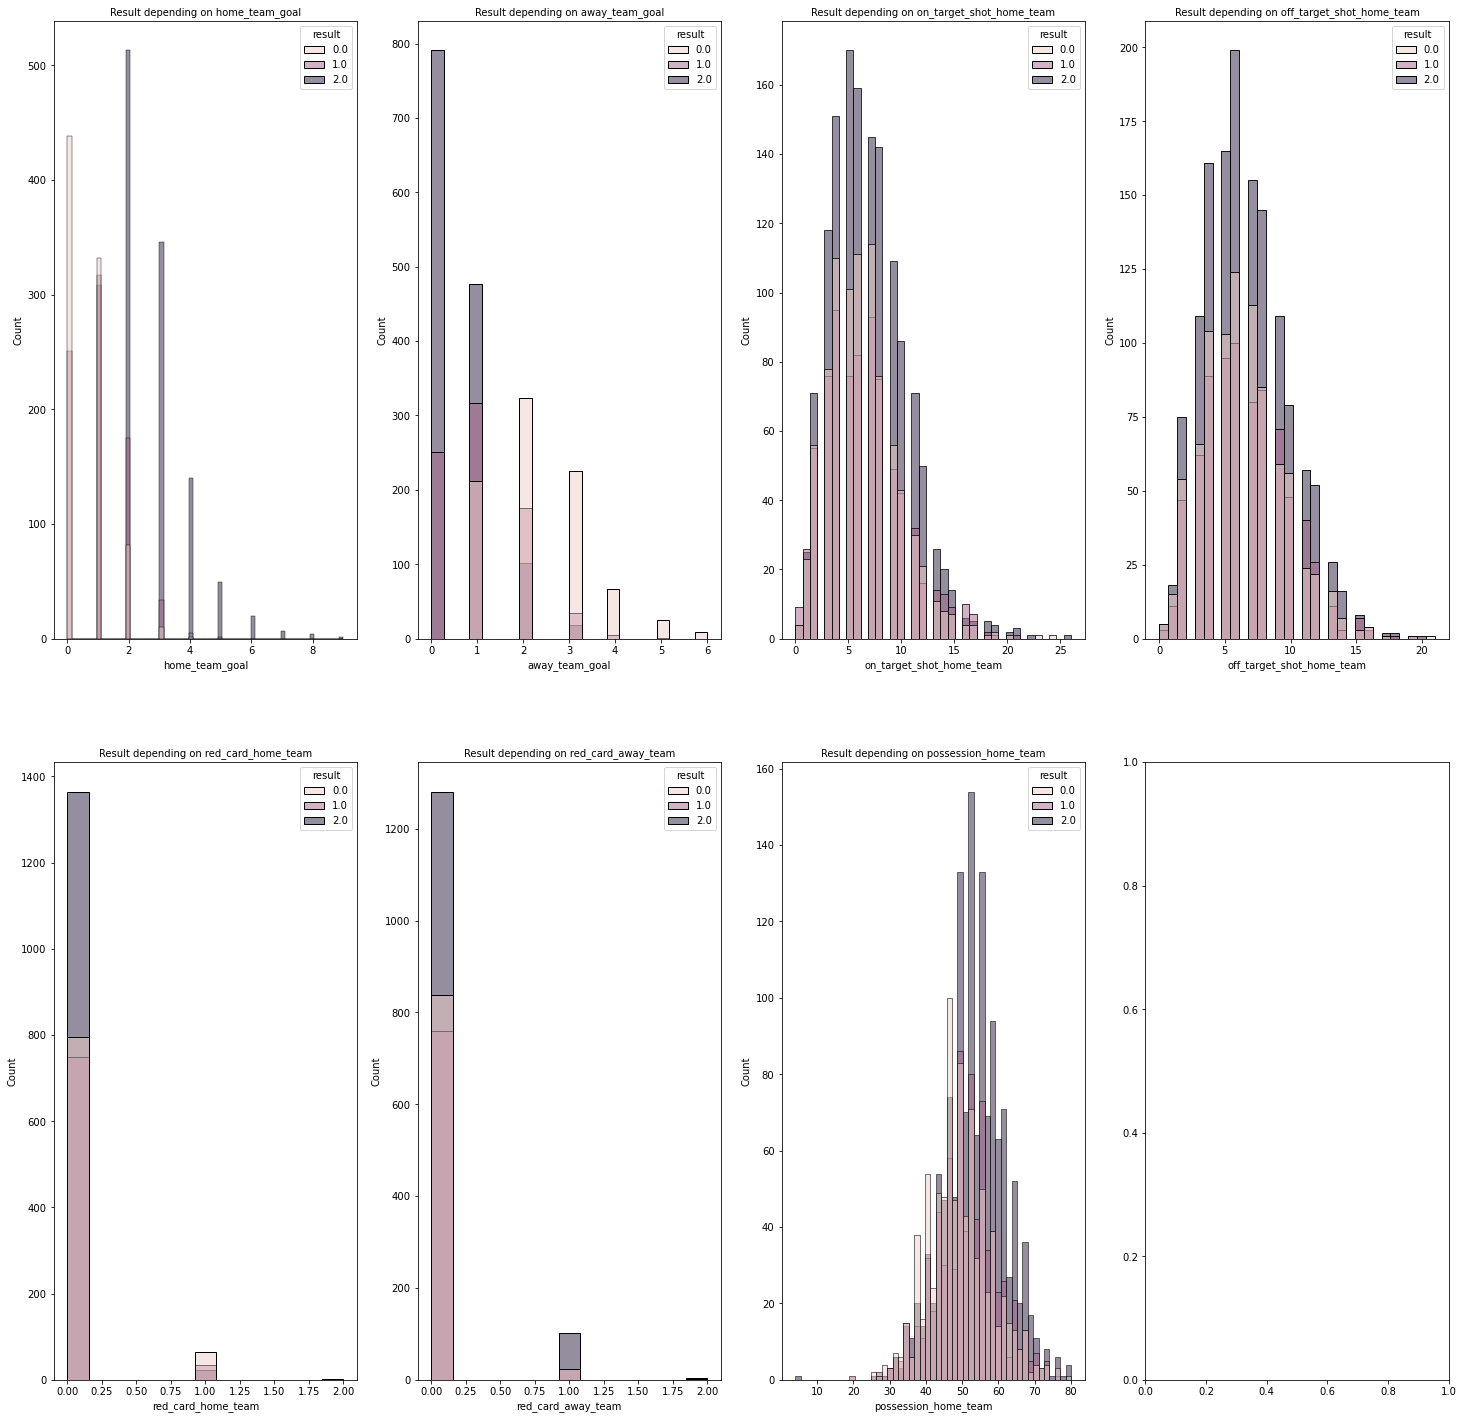

In [17]:
plot_sidebar(df_plot)

## Defining every model and parameters

In [18]:
log_reg_params = [{"C":0.01}, {"C":0.1}, {"C":1},{"C":5}, {"C":10}]
dec_tree_params = [{"criterion": "gini"}, {"criterion": "entropy"}]
rand_for_params = [{"criterion": "gini"}, {"criterion": "entropy"}]
kneighbors_params = [{"n_neighbors":3}, {"n_neighbors":5}]
naive_bayes_params = [{}]
svc_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]

In [19]:
modelclasses = [
    ["log regression", LogisticRegression, log_reg_params],
    ["decision tree", DecisionTreeClassifier, dec_tree_params],
    ["random forest", RandomForestClassifier, rand_for_params],
    ["k neighbors", KNeighborsClassifier, kneighbors_params],
    ["naive bayes", GaussianNB, naive_bayes_params],
    ["support vector machines", SVC, svc_params]
]

## Plot confusion matrix

In [20]:
## Function to show confusion matrix depending on the model
def plot_confusion_matrix(model, train_X, val_X, train_y, val_y):
    model.fit(train_X, train_y)
    train_pred = model.predict(train_X)
    test_pred = model.predict(val_X)
    print(f"Accuracy score for train set : {accuracy_score(train_y, train_pred)} ({round(accuracy_score(train_y, train_pred)*100, 2)}%)")
    print(f"Accuracy score for test set : {accuracy_score(val_y, test_pred)} ({round(accuracy_score(val_y, test_pred)*100, 2)}%)")

    f, axs = plt.subplots(1,2, figsize=(15,15))
    axs = axs.flatten()

    case = [
            ("Confusion matrix - train set", train_y, train_pred),
            ("Confusion matrix - test set", val_y, test_pred),
        ]

    for index, (name, y, pred) in enumerate(case):
        matrix = ConfusionMatrixDisplay.from_predictions(y, pred, labels=[0,1,2],normalize=None, cmap=plt.cm.Greens, ax=axs[index],)
        matrix.ax_.set_title(name)


## First itteration

In [21]:
df1=df.copy()
df1=df1.drop(['shoton','shotoff','foulcommit','card','cross','corner','possession'], axis=1, inplace=False)

In [22]:
df1.describe()

,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,on_target_shot_home_team,on_target_shot_away_team,off_target_shot_home_team,off_target_shot_away_team,foul_home_team,...,yellow_card_away_team,red_card_home_team,red_card_away_team,crosses_home_team,crosses_away_team,corner_home_team,corner_away_team,possession_home_team,possession_away_team,result
count,3.034000e+03,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,...,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000
mean,1.179750e+06,9142.544166,9142.427818,1.552736,1.158207,6.681279,5.274555,6.603823,5.206328,10.692485,...,1.819710,0.041859,0.053065,20.914305,16.248846,6.126895,4.812129,51.676994,48.323006,1.173039
std,4.906884e+05,753.333549,753.178006,1.311651,1.143808,3.511969,2.936536,3.091729,2.669561,3.548268,...,1.293977,0.205179,0.232857,8.737286,7.376841,3.147969,2.719731,8.640939,8.640939,0.843930
min,4.890420e+05,8191.000000,8191.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,20.000000,0.000000
25%,8.397992e+05,8528.000000,8528.000000,1.000000,0.000000,4.000000,3.000000,4.000000,3.000000,8.000000,...,1.000000,0.000000,0.000000,15.000000,11.000000,4.000000,3.000000,46.000000,43.000000,0.000000
50%,1.228230e+06,8659.000000,8659.000000,1.000000,1.000000,6.000000,5.000000,6.000000,5.000000,11.000000,...,2.000000,0.000000,0.000000,20.000000,15.000000,6.000000,4.000000,52.000000,48.000000,1.000000
75%,1.723983e+06,9879.000000,9879.000000,2.000000,2.000000,9.000000,7.000000,9.000000,7.000000,13.000000,...,3.000000,0.000000,0.000000,26.000000,21.000000,8.000000,6.000000,57.000000,54.000000,2.000000
max,1.989079e+06,10261.000000,10261.000000,9.000000,6.000000,26.000000,19.000000,21.000000,19.000000,26.000000,...,9.000000,2.000000,2.000000,72.000000,55.000000,20.000000,19.000000,80.000000,96.000000,2.000000


In [23]:
df1.head()

,season,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,on_target_shot_home_team,...,yellow_card_away_team,red_card_home_team,red_card_away_team,crosses_home_team,crosses_away_team,corner_home_team,corner_away_team,possession_home_team,possession_away_team,result
0,2008/2009,2008-08-16 00:00:00,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,12,...,0,0,0,21,7,7,5,66.0,34.0,2.0
1,2008/2009,2008-08-16 00:00:00,489044,8472,Sunderland,8650,Liverpool,0,1,4,...,2,0,0,15,19,1,8,46.0,54.0,0.0
2,2008/2009,2008-08-16 00:00:00,489045,8654,West Ham United,8528,Wigan Athletic,2,1,5,...,1,0,0,15,27,6,10,52.0,48.0,2.0
3,2008/2009,2008-08-16 00:00:00,489047,8668,Everton,8655,Blackburn Rovers,2,3,2,...,2,0,0,14,21,3,4,51.0,49.0,0.0
4,2008/2009,2008-08-16 00:00:00,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,7,...,2,0,0,25,27,7,9,53.0,47.0,2.0


In [24]:
df1.columns

Index(['season', 'date', 'match_api_id', 'home_team_api_id', 'home_team',
       'away_team_api_id', 'away_team', 'home_team_goal', 'away_team_goal',
       'on_target_shot_home_team', 'on_target_shot_away_team',
       'off_target_shot_home_team', 'off_target_shot_away_team',
       'foul_home_team', 'foul_away_team', 'yellow_card_home_team',
       'yellow_card_away_team', 'red_card_home_team', 'red_card_away_team',
       'crosses_home_team', 'crosses_away_team', 'corner_home_team',
       'corner_away_team', 'possession_home_team', 'possession_away_team',
       'result'],
      dtype='object')

In [25]:
## I define first the features
features=df1.loc[:, 'on_target_shot_home_team':'possession_away_team'].columns
features

Index(['on_target_shot_home_team', 'on_target_shot_away_team',
       'off_target_shot_home_team', 'off_target_shot_away_team',
       'foul_home_team', 'foul_away_team', 'yellow_card_home_team',
       'yellow_card_away_team', 'red_card_home_team', 'red_card_away_team',
       'crosses_home_team', 'crosses_away_team', 'corner_home_team',
       'corner_away_team', 'possession_home_team', 'possession_away_team'],
      dtype='object')

In [26]:
X=df1[features]
y=df1.result
X.describe()

,on_target_shot_home_team,on_target_shot_away_team,off_target_shot_home_team,off_target_shot_away_team,foul_home_team,foul_away_team,yellow_card_home_team,yellow_card_away_team,red_card_home_team,red_card_away_team,crosses_home_team,crosses_away_team,corner_home_team,corner_away_team,possession_home_team,possession_away_team
count,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000
mean,6.681279,5.274555,6.603823,5.206328,10.692485,11.400461,1.433092,1.819710,0.041859,0.053065,20.914305,16.248846,6.126895,4.812129,51.676994,48.323006
std,3.511969,2.936536,3.091729,2.669561,3.548268,3.686908,1.172118,1.293977,0.205179,0.232857,8.737286,7.376841,3.147969,2.719731,8.640939,8.640939
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,20.000000
25%,4.000000,3.000000,4.000000,3.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,15.000000,11.000000,4.000000,3.000000,46.000000,43.000000
50%,6.000000,5.000000,6.000000,5.000000,11.000000,11.000000,1.000000,2.000000,0.000000,0.000000,20.000000,15.000000,6.000000,4.000000,52.000000,48.000000
75%,9.000000,7.000000,9.000000,7.000000,13.000000,14.000000,2.000000,3.000000,0.000000,0.000000,26.000000,21.000000,8.000000,6.000000,57.000000,54.000000
max,26.000000,19.000000,21.000000,19.000000,26.000000,25.000000,7.000000,9.000000,2.000000,2.000000,72.000000,55.000000,20.000000,19.000000,80.000000,96.000000


In [27]:
##WE can start to test classification models
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.2)

c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score for train set : 0.526988051091883 (52.7%)
Accuracy score for test set : 0.5090609555189456 (50.91%)


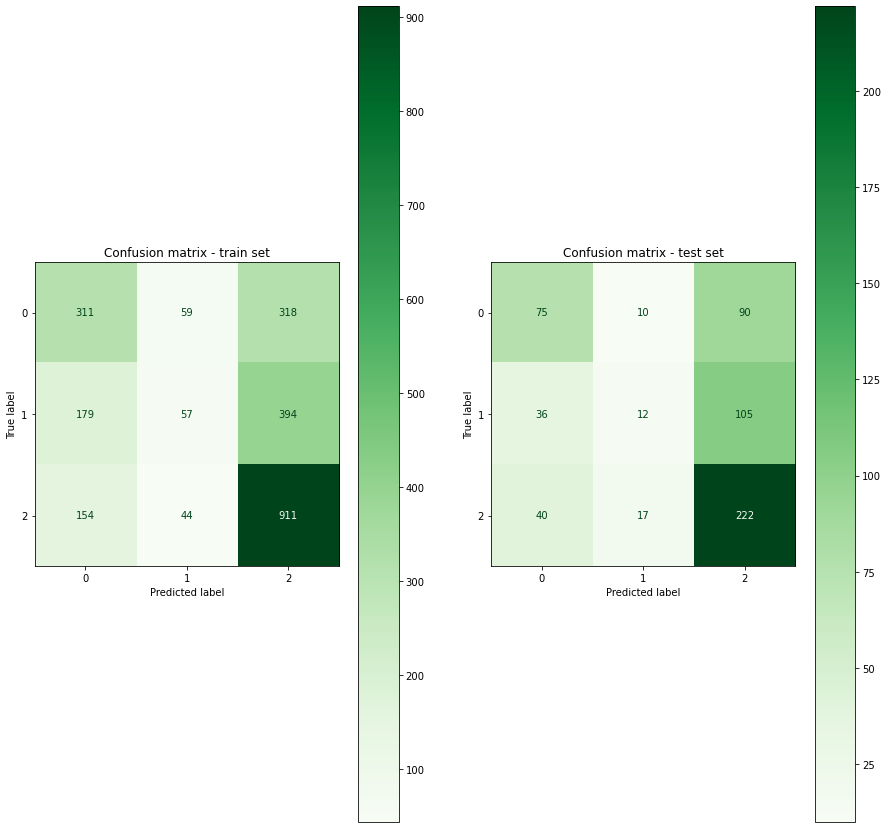

In [28]:
plot_confusion_matrix(LogisticRegression(C=1), train_X, val_X, train_y, val_y)

In [29]:
##Calculating accuracy with every models defined above
insights = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(train_X, train_y)
        score = model.score(val_X, val_y)   
        insights.append((modelname, model, params, score))    

c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

In [30]:
insights.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score in insights:
    print(modelname, params, score)

support vector machines {'C': 1} 0.5255354200988468
support vector machines {'C': 10} 0.5205930807248764
log regression {'C': 1} 0.5090609555189456
log regression {'C': 0.01} 0.5074135090609555
log regression {'C': 5} 0.5041186161449753
random forest {'criterion': 'entropy'} 0.5041186161449753
log regression {'C': 0.1} 0.5024711696869851
log regression {'C': 10} 0.5024711696869851
naive bayes {} 0.49917627677100496
random forest {'criterion': 'gini'} 0.48105436573311366
support vector machines {'C': 0.1} 0.471169686985173
support vector machines {'C': 0.01} 0.4596375617792422
k neighbors {'n_neighbors': 5} 0.4316309719934102
k neighbors {'n_neighbors': 3} 0.4200988467874794
decision tree {'criterion': 'entropy'} 0.4184514003294893
decision tree {'criterion': 'gini'} 0.3772652388797364


## SECOND TRY WITH DIFFERENCE VECT

In [31]:
##TRY WITH DIFFERENCE VECTOR / Here since there are a lot of features, I want to reduce the number of features by using the difference vector explained in the report
## Notice that "card" is taking in consideration only the red cards since the yellows aren't important
df2=df.copy()
df2['card']= df2['red_card_away_team'] - df2['red_card_home_team'] 
df2['cross']=df2['crosses_home_team'] - df2['crosses_away_team']
df2['corner']=df2['corner_home_team'] - df2['corner_away_team']
df2['possession']=df2['possession_home_team']
df2['shoton']=df2['on_target_shot_home_team']-df2['on_target_shot_away_team']
df2['shotoff']=df2['off_target_shot_home_team']-df2['off_target_shot_away_team']

In [32]:
##We drop columns that we dont need anymore
df2=df2.drop(['foulcommit','yellow_card_away_team','yellow_card_home_team','red_card_home_team','red_card_away_team','crosses_home_team','crosses_away_team','corner_home_team','corner_away_team','possession_home_team','possession_away_team'], axis=1, inplace=False)

In [33]:
df2.head()

,season,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,shoton,...,cross,corner,possession,on_target_shot_home_team,on_target_shot_away_team,off_target_shot_home_team,off_target_shot_away_team,foul_home_team,foul_away_team,result
0,2008/2009,2008-08-16 00:00:00,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,10,...,14,2,66.0,12,2,13,3,11,9,2.0
1,2008/2009,2008-08-16 00:00:00,489044,8472,Sunderland,8650,Liverpool,0,1,-7,...,-4,-7,46.0,4,11,3,5,13,12,0.0
2,2008/2009,2008-08-16 00:00:00,489045,8654,West Ham United,8528,Wigan Athletic,2,1,-2,...,-12,-4,52.0,5,7,7,15,14,13,2.0
3,2008/2009,2008-08-16 00:00:00,489047,8668,Everton,8655,Blackburn Rovers,2,3,-6,...,-7,-1,51.0,2,8,7,8,11,11,0.0
4,2008/2009,2008-08-16 00:00:00,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,5,...,-2,-2,53.0,7,2,5,5,11,11,2.0


In [34]:
df2.columns

Index(['season', 'date', 'match_api_id', 'home_team_api_id', 'home_team',
       'away_team_api_id', 'away_team', 'home_team_goal', 'away_team_goal',
       'shoton', 'shotoff', 'card', 'cross', 'corner', 'possession',
       'on_target_shot_home_team', 'on_target_shot_away_team',
       'off_target_shot_home_team', 'off_target_shot_away_team',
       'foul_home_team', 'foul_away_team', 'result'],
      dtype='object')

In [35]:
##Select the columns names between card and result
features=[ 'card','cross','corner','possession','shoton','shotoff']
features

['card', 'cross', 'corner', 'possession', 'shoton', 'shotoff']

In [36]:
X=df2[features]
y=df2.result
X.describe()

,card,cross,corner,possession,shoton,shotoff
count,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000
mean,0.011206,4.665458,1.314766,51.676994,1.406724,1.397495
std,0.305796,11.931216,4.616746,8.640939,4.990730,4.469430
min,-2.000000,-41.000000,-16.000000,4.000000,-16.000000,-14.000000
25%,0.000000,-3.000000,-2.000000,46.000000,-2.000000,-2.000000
50%,0.000000,4.000000,1.000000,52.000000,1.000000,1.000000
75%,0.000000,12.000000,4.000000,57.000000,4.000000,4.000000
max,2.000000,66.000000,19.000000,80.000000,25.000000,19.000000


In [37]:
##WE can start to test classification models
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

model=tree.DecisionTreeClassifier(random_state=1)
model.fit(train_X, train_y)
val_predictions = model.predict(val_X)
##number of value in numpy array
val_predictions.shape
y.shape

(3034,)

In [38]:
confusion_matrix(val_y,val_predictions,labels=[0,1,2])
##We have around 46.4% accuracy for home team win prediction

array([[ 79,  61,  80],
       [ 52,  57,  85],
       [ 93,  89, 163]], dtype=int64)

In [39]:
mean_absolute_error(val_y, val_predictions)

0.83399209486166

In [40]:
insights = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(train_X, train_y)
        score = model.score(val_X, val_y)   
        insights.append((modelname, model, params, score))          


c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

In [41]:
insights.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score in insights:
    print(modelname, params, score)

support vector machines {'C': 10} 0.5204216073781291
log regression {'C': 0.01} 0.5191040843214756
log regression {'C': 10} 0.5177865612648221
log regression {'C': 5} 0.5164690382081687
log regression {'C': 1} 0.5151515151515151
log regression {'C': 0.1} 0.5138339920948617
support vector machines {'C': 1} 0.5111989459815547
naive bayes {} 0.5019762845849802
support vector machines {'C': 0.1} 0.49538866930171277
random forest {'criterion': 'entropy'} 0.463768115942029
support vector machines {'C': 0.01} 0.45454545454545453
random forest {'criterion': 'gini'} 0.45322793148880103
k neighbors {'n_neighbors': 5} 0.43873517786561267
k neighbors {'n_neighbors': 3} 0.43478260869565216
decision tree {'criterion': 'entropy'} 0.4057971014492754
decision tree {'criterion': 'gini'} 0.3939393939393939


## THIRD TRY

In [42]:
#I will try with the statistic of shot of the home team
df3=df2.drop(['on_target_shot_away_team'], axis=1, inplace=False)


In [43]:
##Now we will try to change some features
feature=df3.loc[:, 'shoton':'off_target_shot_home_team'].columns
feature

Index(['shoton', 'shotoff', 'card', 'cross', 'corner', 'possession',
       'on_target_shot_home_team', 'off_target_shot_home_team'],
      dtype='object')

In [44]:
X=df3[feature]
y=df3.result
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size=0.2)
model=tree.DecisionTreeClassifier(random_state=1)
model.fit(train_X, train_y)
val_predictions = model.predict(val_X)
confusion_matrix(val_y,val_predictions,labels=[0,1,2])
##After reducing the number of features now we have 53.4% accuracy for home team win prediction


array([[ 56,  64,  55],
       [ 44,  40,  69],
       [ 53,  90, 136]], dtype=int64)

c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score for train set : 0.526988051091883 (52.7%)
Accuracy score for test set : 0.5271828665568369 (52.72%)


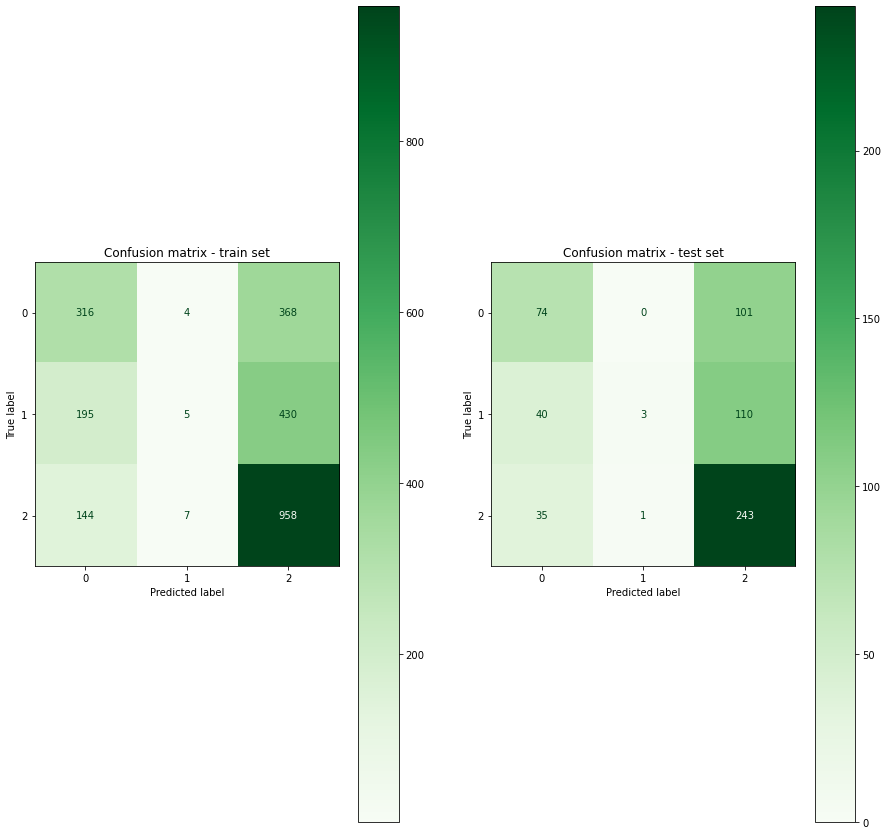

In [45]:
plot_confusion_matrix(LogisticRegression(C=10), train_X, val_X, train_y, val_y)

In [46]:
accuracy_score(val_y,val_predictions)

0.38220757825370677

In [47]:
model.score(val_X,val_y)

0.38220757825370677

In [48]:
insights = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(train_X, train_y)
        score = model.score(val_X, val_y)   
        insights.append((modelname, model, params, score))          

c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

In [49]:
insights.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score in insights:
    print(modelname, params, score)

log regression {'C': 10} 0.5271828665568369
log regression {'C': 5} 0.5255354200988468
log regression {'C': 0.1} 0.5238879736408567
log regression {'C': 1} 0.5238879736408567
log regression {'C': 0.01} 0.5222405271828665
support vector machines {'C': 10} 0.5222405271828665
support vector machines {'C': 1} 0.5205930807248764
support vector machines {'C': 0.1} 0.5074135090609555
random forest {'criterion': 'entropy'} 0.4942339373970346
random forest {'criterion': 'gini'} 0.49093904448105435
naive bayes {} 0.48929159802306427
support vector machines {'C': 0.01} 0.4596375617792422
k neighbors {'n_neighbors': 5} 0.43657331136738053
k neighbors {'n_neighbors': 3} 0.42504118616144976
decision tree {'criterion': 'entropy'} 0.41186161449752884
decision tree {'criterion': 'gini'} 0.40362438220757824


## The best result obtained is 0.528 with the features ['card', 'cross', 'corner', 'possession', 'on_target_shot_home_team','off_target_shot_home_team'], Thus we will keep this and try to improve theses features by adding the % of winrate of the home team againts the opponent.

## Cross validation kfold

In [50]:
## Trying cross validation kfold
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RFC', RandomForestClassifier()))


results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, train_X, train_y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.528215 (0.025485)
LDA: 0.529863 (0.024893)
CART: 0.388557 (0.019031)
NB: 0.490312 (0.018890)
SVM: 0.458992 (0.015318)
RFC: 0.490712 (0.026320)


## Adding winrate of the home team againts the opponent

In [51]:
##print every row in df
df4=df3.copy()
df4.head()
##Create column for winrate
df4['winrate']=None
df4.head()



,season,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,shoton,...,cross,corner,possession,on_target_shot_home_team,off_target_shot_home_team,off_target_shot_away_team,foul_home_team,foul_away_team,result,winrate
0,2008/2009,2008-08-16 00:00:00,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,10,...,14,2,66.0,12,13,3,11,9,2.0,None
1,2008/2009,2008-08-16 00:00:00,489044,8472,Sunderland,8650,Liverpool,0,1,-7,...,-4,-7,46.0,4,3,5,13,12,0.0,None
2,2008/2009,2008-08-16 00:00:00,489045,8654,West Ham United,8528,Wigan Athletic,2,1,-2,...,-12,-4,52.0,5,7,15,14,13,2.0,None
3,2008/2009,2008-08-16 00:00:00,489047,8668,Everton,8655,Blackburn Rovers,2,3,-6,...,-7,-1,51.0,2,7,8,11,11,0.0,None
4,2008/2009,2008-08-16 00:00:00,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,5,...,-2,-2,53.0,7,5,5,11,11,2.0,None


In [52]:
def get_winrate(row):

    """
    Given a pd.DataFrame of encounters between two teams, I
    extract the win percentage and possession_percentage
    of the specified team.
    
    For each match, if it was a draw, I count it as a
    win for *both* teams (and so increases the total count
    by 2).
    
    If there were no encounters between the two teams,
    returns -1.
    """
    date = row['date']
    #print(row['home_team'], row['away_team'])
    ## Here we select from the database every match in which the home team and the away team are facing each other
    match=df[((df['home_team']==row['home_team']) & (df['away_team']==row['away_team'])) | ((df['home_team']==row['away_team']) & (df['away_team']==row['home_team']))]
    if  len(match.index) ==0:
        return -1,-1
    win=0
    totalpos=0
    total=len(match.index)
    totalmatch=len(match.index)
    ## if the game was a draw, we count it as a win for both teams
    for (index,item) in match.iterrows():
        ##winrate
        if match.loc[index,'result']==1:
            win+=1
            total+=1
        elif ((match.loc[index,'result']==2 and match.loc[index,'home_team']==row['home_team']) or (match.loc[index,'result']==0 and match.loc[index,'away_team']==row['home_team'])):
            win+=1
        ## possess
        if match.loc[index,'home_team']==row['home_team']:
            totalpos+=match.loc[index,'possession_home_team']
        elif match.loc[index,'away_team']==row['home_team']:
            totalpos+=match.loc[index,'possession_away_team']   
    
    winrate=(win/total)*100
    possession_avg=(totalpos)/(totalmatch)
    return possession_avg, winrate


In [53]:
for index, row in df4.iterrows():
    possession_avg,winrate=get_winrate(row)
    df4.loc[index,'winrate']=winrate
    df4.loc[index,'possession']=possession_avg


In [54]:
## print every line where arsenal and everton are facing each other to see if we can predict the winrate efficiently 
df4[((df4['home_team']=='Arsenal') & (df4['away_team']=='Everton')) | ((df4['home_team']=='Everton') & (df4['away_team']=='Arsenal'))].head()

,season,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,shoton,...,cross,corner,possession,on_target_shot_home_team,off_target_shot_home_team,off_target_shot_away_team,foul_home_team,foul_away_team,result,winrate
70,2008/2009,2008-10-18 00:00:00,489113,9825,Arsenal,8668,Everton,3,1,7,...,14,3,52.0625,11,8,2,9,13,2.0,68.181818
223,2008/2009,2009-01-28 00:00:00,489269,8668,Everton,9825,Arsenal,1,1,0,...,-2,1,47.9375,4,4,3,10,14,1.0,31.818182
381,2009/2010,2009-08-15 00:00:00,658576,8668,Everton,9825,Arsenal,1,6,1,...,-6,-5,47.9375,5,3,8,11,12,0.0,31.818182
578,2009/2010,2010-01-09 00:00:00,658945,9825,Arsenal,8668,Everton,2,2,0,...,10,-3,52.0625,5,0,2,9,7,1.0,68.181818
888,2010/2011,2010-11-14 00:00:00,839937,8668,Everton,9825,Arsenal,1,2,8,...,22,7,47.9375,13,7,6,16,14,0.0,31.818182


## LAST TRY:

In [55]:
## Now I will try to add the new features to the model
df4.columns
df4.shape

(3034, 22)

In [56]:
feature=['card', 'cross', 'corner', 'possession', 'on_target_shot_home_team','off_target_shot_home_team','winrate']
feature

['card',
 'cross',
 'corner',
 'possession',
 'on_target_shot_home_team',
 'off_target_shot_home_team',
 'winrate']

In [57]:
X=df4[feature]
y=df4.result
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size=0.2)

Accuracy score for train set : 0.5850844664194479 (58.51%)
Accuracy score for test set : 0.6029654036243822 (60.3%)


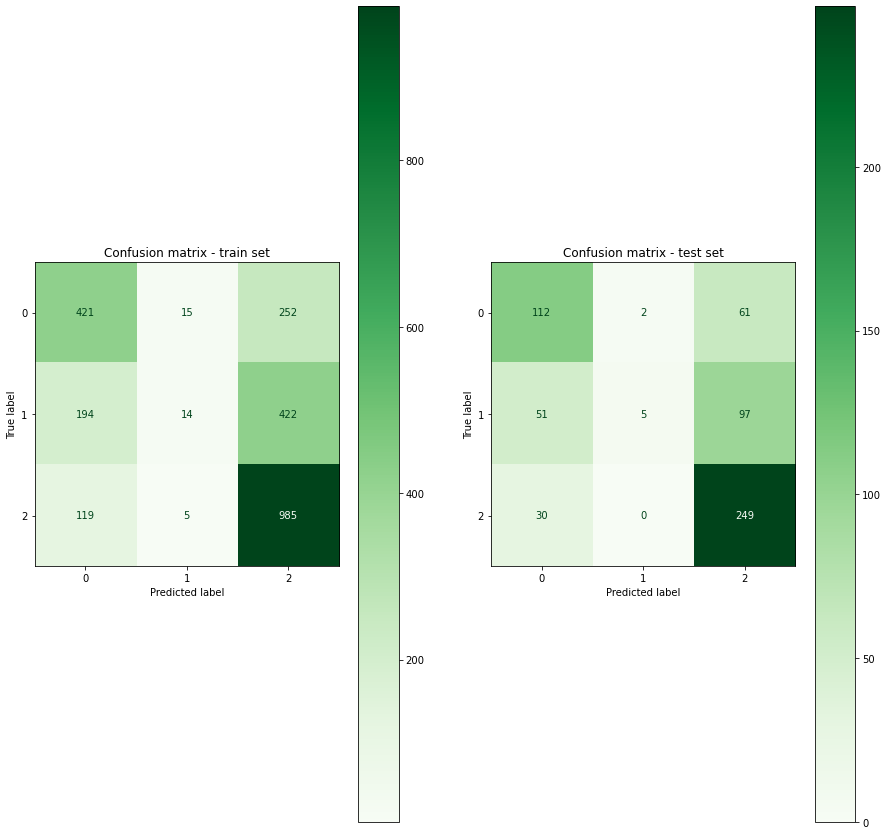

In [58]:
plot_confusion_matrix(SVC(C=0.1), train_X, val_X, train_y, val_y)

In [59]:
insights = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(train_X, train_y)
        score = model.score(val_X, val_y)   
        insights.append((modelname, model, params, score))    

c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

In [60]:
insights.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score in insights:
    print(modelname, params, score)

support vector machines {'C': 0.1} 0.6029654036243822
support vector machines {'C': 1} 0.6013179571663921
log regression {'C': 0.1} 0.5980230642504119
log regression {'C': 1} 0.5963756177924218
log regression {'C': 5} 0.5963756177924218
random forest {'criterion': 'gini'} 0.5947281713344317
log regression {'C': 10} 0.5930807248764415
random forest {'criterion': 'entropy'} 0.5930807248764415
support vector machines {'C': 10} 0.5914332784184514
support vector machines {'C': 0.01} 0.586490939044481
log regression {'C': 0.01} 0.5848434925864909
naive bayes {} 0.5601317957166392
k neighbors {'n_neighbors': 3} 0.5420098846787479
k neighbors {'n_neighbors': 5} 0.5370675453047776
decision tree {'criterion': 'gini'} 0.5123558484349259
decision tree {'criterion': 'entropy'} 0.5107084019769358


In [61]:
X=df4[feature].iloc[-5:]
X

,card,cross,corner,possession,on_target_shot_home_team,off_target_shot_home_team,winrate
3035,0,-5,-6,50.642857,3,2,52.631579
3036,0,-1,0,48.800000,1,2,25.0
3037,0,-3,3,51.000000,6,10,66.666667
3038,0,-2,2,40.571429,5,8,44.444444
3039,0,11,6,62.500000,5,4,50.0


## Find How many games to take into consideration to have better accuracy

In [62]:
# Find how many previous game should I take in the data to have the best accuracy

def get_best_number(data,model,nb_games):
    """
    Given a dataframe of games, a model and a number of previous games,
    returns the number of previous games that gives the best accuracy.
    """
    feature=['card', 'cross', 'corner', 'possession', 'on_target_shot_home_team','off_target_shot_home_team','winrate']
    best_number = 0
    best_score = 0
    for i in range(nb_games, 100, -100):
        X = data[feature].iloc[-i:]
        y = data.result.iloc[-i:]
        train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size=0.2)
        model.fit(train_X, train_y)
        score = model.score(val_X, val_y)
        if score > best_score:
            best_number = i
            best_score = score
    #Plot confusion matrix
    f, axs = plt.subplots(1,2, figsize=(15,15))
    axs = axs.flatten()
    X = data[feature].iloc[-best_number:]
    y = data.result.iloc[-best_number:]
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size=0.2)
    train_pred = model.predict(train_X)
    test_pred = model.predict(val_X)
    case = [
        ("Confusion matrix - train set", train_y, train_pred),
        ("Confusion matrix - test set", val_y, test_pred),
    ]

    for index, (name, y, pred) in enumerate(case):
        matrix = ConfusionMatrixDisplay.from_predictions(y, pred, labels=[0,1,2],normalize=None, cmap=plt.cm.Greens, ax=axs[index],)
        matrix.ax_.set_title(name)

    return best_number, best_score

c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Anaconda\envs\datas\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

1800 0.6388888888888888


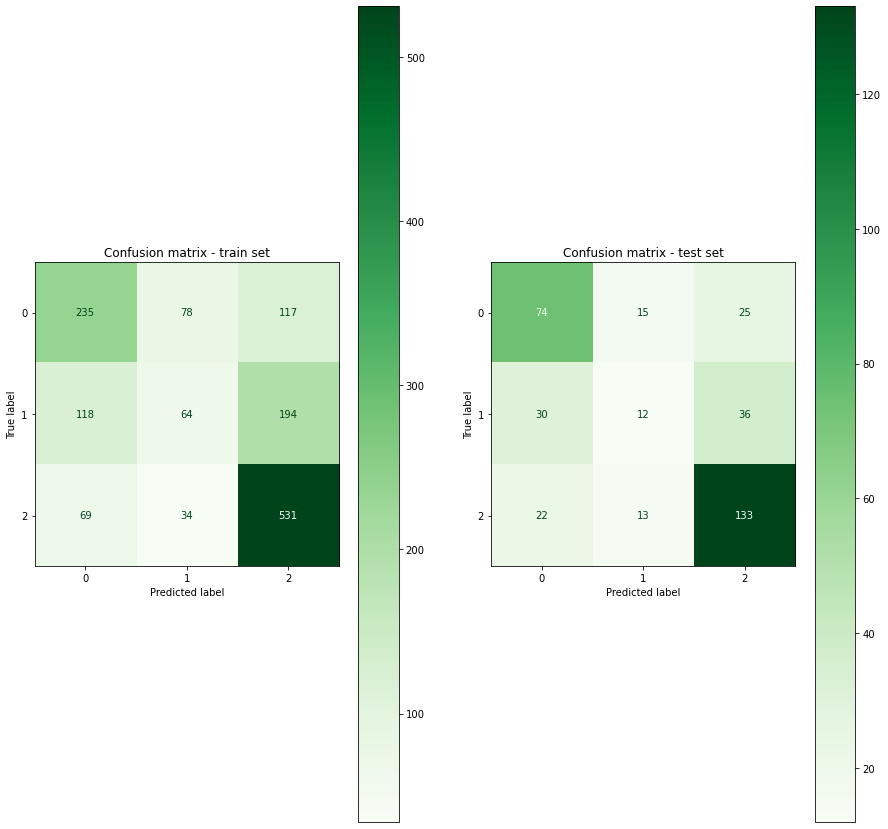

In [64]:
bestnumb,best_score=get_best_number(df4,LogisticRegression(C=1),3000)
print(bestnumb,best_score);